In [1]:
def create_single_variable_mosaic_plot_pctlabels(ax, data, split_variable, order, color_mapping, title):
           
    # Count the occurrences and reshape for mosaic plot
    count_data = data[split_variable].value_counts().reindex(order, fill_value=0)
    
    # Convert to dictionary format suitable for mosaic plot
    mosaic_data = count_data.to_dict()
    
    # Function to specify properties including colors based on cross_variable
    def props(key):
        # Extract category from key if it's a tuple
        if isinstance(key, tuple):
            category = key[0]  # Extract the first element from the tuple
        else:
            category = key  # Use directly if it's not a tuple
        color = color_mapping.get(category, (0.0, 0.0, 0.0, 0.6))  # Default to black if not found
        return {'color': color}
    
    # Calculate total number of occurrences for percentage calculation
    total_count = count_data.sum()
    
    # Plot the mosaic plot with automatic labels
    labelizer = lambda key: ''
    fig, rects = mosaic(mosaic_data, title='', labelizer = labelizer, properties=props, ax=ax, gap=0.015, horizontal=True)
    ax.invert_yaxis()  # Optional: Invert y-axis to match standard bar plot orientation
    ax.set_xticklabels([])  # Remove x-axis labels
    
    the_ls = range(0,len(order))
    if split_variable == 'Loading_profile_molly': 
        the_ls = [the_ls[0]] + [x * 6 for x in the_ls[1:]]
    else:
        the_ls = [the_ls[0]] + [x * 4 for x in the_ls[1:]]

    # Manually replace the labels with percentage labels
    counter=0
    for key, (x1, y1, x2, y2) in rects.items():
        count = mosaic_data[key[0]]
        percentage = (count / total_count) * 100
        label = f'{percentage:.2f}%'
        
        # Find the label at this position and replace its text
        for text in ax.texts:
            if counter in the_ls:
                text.set_text(label)
                text.set_fontsize(10)
                text.set_color('black')
            counter=counter+1
            
    for key, (x1, y1, x2, y2) in rects.items():
        if x1 == 0:  # Check if this is the leftmost bar
            ax.text(x1-0.01, (y1 + y2) / 2, title, va='center', ha='right', fontsize=15, color='black', weight='bold')  

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
import iris
import iris.coord_categorisation
import sys
import time
import datetime
from datetime import datetime

sys.path.insert(1, '../Finding_AMAX_Events')
from Identify_Events_Functions import *
from New_Identify_Events_Functions import *
# sys.path.insert(1, '../../ProcessEvents')
# from Get_Events_Functions import *

sys.path.insert(1, '../../ProcessEvents')
from Convert_to_Profiles_Functions import *
from Get_Events_Functions import *
from Steef_Functions import *

home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

em = 'bb208'
yrs_range= '2060_2081'
sample_cube = iris.load(home_dir + f'datadir/UKCP18_every30mins/2.2km_bng/{yrs_range}/{em}/bng_{em}a.pr206101.nc')[0][1,:,:]
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

In [3]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}

In [4]:
trimmed_event = remove_leading_and_trailing_zeroes(this_event)

NameError: name 'this_event' is not defined

In [ ]:
def find_max_quintile (precip, n):
    # Difference with this to Huff curve function, is it doesnt normalise
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
    dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall,n)
    interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
    max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    
    return max_quintile_profile 


In [ ]:
def create_event_characteristics_dict(this_event):
    
    max_quintile_molly=find_max_quintile(this_event['precipitation (mm)'],5)
    max_third_molly=find_max_quintile(this_event['precipitation (mm)'],3)
    max_quintile_steef=analyse_event(this_event['precipitation (mm)'])[0]
    duration = len(this_event) / 2
    DurationRange_personalised_allems = find_dur_category([1.5, 5.0, 11.5, 22.5, 166.5], ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr'], duration)
    DurationRange_notpersonalised = find_dur_category([0.25, 2.10, 6.45, 19.25, 1000], 
                                                      ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr'], duration)
    return {
        "season" : get_season(this_event['times'][0]),
        'duration':duration,
        "DurationRange_personalised_allems": DurationRange_personalised_allems,
        'DurationRange_notpersonalised':DurationRange_notpersonalised,
        "year":extract_year(this_event),
        'Volume': sum(this_event['precipitation (mm)'].values),
        "max_quintile_molly":max_quintile_molly,
        "max_third_molly": max_third_molly,
        'max_quintile_steef' :max_quintile_steef,
        'Loading_profile_molly' :quintile_mapping[max_quintile_molly],
        'Loading_profile_third_molly':quintile_mapping_thirds[max_third_molly],
        'Loading_profile_steef':quintile_mapping[max_quintile_steef],
    }


def create_profiles_dict(this_event):
    dimensionless_cumulative_rainfall, dimensionless_cumulative_times = create_huff_curves(this_event['precipitation (mm)'])
    interpolated_cumulative_rainfall, interpolated_times = interpolate_rainfall(dimensionless_cumulative_rainfall,12)
    irain_14vals, irain_times_14vals = create_irain_profile(interpolated_cumulative_rainfall, True)
    irain, irain_times = create_irain_profile(interpolated_cumulative_rainfall, False)
    return {
        "dimensionless_cumulative_rainfall" : dimensionless_cumulative_rainfall,
        'dimensionless_cumulative_times':dimensionless_cumulative_times,
        "interpolated_cumulative_rainfall": interpolated_cumulative_rainfall,
        'interpolated_times':interpolated_times,
        "irain_14vals":irain_14vals,
        'irain_times_14vals': irain_times_14vals,
        "irain":irain,
        "irain_times": irain_times} 

In [ ]:
def find_dur_category (bin_edges, duration_labels, duration):
    # Create a pandas Series with the duration
    # Use pd.cut to assign the duration to a bin
    binned_duration = pd.cut(pd.Series([duration]), bins=bin_edges, labels=duration_labels, right=True,  include_lowest=True)
    return binned_duration.iloc[0]

## Create one set of events across all gauges

In [8]:
start_time = time.time()
all_gauge_top_18_6h_events =[]
for gauge_num in range(0,1294):
    Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(tbo_vals, gauge_num, sample_cube)
    full_timeslice_cube = iris.load(home_dir + f'datadir/Gauge_Timeslices/2060_2081/{em}/gauge{gauge_num}_farFuture.nc')[0]
    precip_data = full_timeslice_cube.data
    time_coord = full_timeslice_cube.coord('time')
    my_events = my_find_independent_events(precip_data, time_coord, Tb0)
    top_18_6h_events = find_top_n_events_for_duration(my_events, n_events = 18, duration_in_hrs = 6)
    all_gauge_top_18_6h_events.extend(top_18_6h_events)
my_duration = time.time() - start_time
print(f"My code took {my_duration:.4f} seconds.")    

NameError: name 'convert_timeformat_array' is not defined

### Process them

In [6]:
def convert_timeformat_array(time_coord, time_points):
    """
    Convert time points from Iris time coordinates to human-readable datetime format.
    
    Parameters:
    - time_coord: The time coordinate from the Iris cube (e.g., cube.coord('time'))
    - time_points: The array of numerical time points to be converted (e.g., time_coord.points)
    
    Returns:
    - A list of human-readable datetime strings corresponding to the time points.
    """
    # Get the units and calendar from the time coordinate
    time_unit = time_coord.units
    calendar = time_coord.units.calendar
    
    # Convert the time points to datetime objects
    datetimes = [cftime.num2date(time, time_unit.origin, calendar) for time in time_points]
    
    # Format the datetimes into human-readable strings (e.g., YYYY-MM-DD HH:MM:SS)
    formatted_times = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in datetimes]
    
    return formatted_times


In [7]:
events_dict={}
event_props_dict={}
event_profiles_dict = {}

for event_num, event in enumerate(all_gauge_top_18_6h_events):

    try:
        event_times = convert_timeformat_array(time_coord[0], event[2].points)
    except:
        event_times = convert_timeformat_array(time_coord[0], event[2])

    event_df = pd.DataFrame({'precipitation (mm)': event[1], 'times': event_times})
    event_props = create_event_characteristics_dict(event_df)
    event_profiles = create_profiles_dict(event_df)
    
    events_dict[event_num]  =event_df
    event_props_dict[event_num] =  event_props
    event_profiles_dict[event_num] = event_profiles

NameError: name 'all_gauge_top_18_6h_events' is not defined

In [19]:
# import pickle
# time_period = 'Future'
# profiles_fp = f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/{time_period}/{em}/"
# with open(profiles_fp + "df.pkl", 'rb') as file:
#     df =pickle.load(file)

In [214]:
profiles = []
for one_dict, the_dict in event_props_dict.items():
    profiles.append(the_dict['Loading_profile_molly'])
profiles_df =pd.DataFrame({"Loading_profile_molly":profiles})

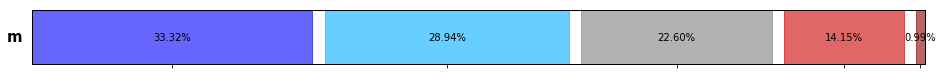

In [215]:
# Create the subplots
fig, axs = plt.subplots(figsize=(16, 1), sharex=True)

create_single_variable_mosaic_plot_pctlabels(axs, profiles_df, 'Loading_profile_molly', 
    quintile_cats, color_mapping, "m")

In [223]:
def calculate_D50(precipitation_values):
    """
    Calculate D50, the point in time when 50% of cumulative precipitation has occurred during an event.
    
    Parameters:
    - precipitation_values: A list or array of precipitation values for a given event.
    
    Returns:
    - D50: The percentage of the event elapsed when 50% of cumulative precipitation has occurred.
    - D50_index: The index where 50% of cumulative precipitation has occurred.
    - cumulative_precip: The cumulative precipitation values for the event.
    """
    # Ensure input is a numpy array
    precipitation_values = np.array(precipitation_values)
    
    # Step 1: Calculate the cumulative precipitation
    cumulative_precip = np.cumsum(precipitation_values)
    
    # Step 2: Determine the total precipitation
    total_precip = cumulative_precip[-1]
    
    # Step 3: Find the index where 50% of the total precipitation is reached
    halfway_precip = total_precip / 2.0
    D50_index = np.where(cumulative_precip >= halfway_precip)[0][0]  # First index where cumulative precipitation >= 50%
    
    # Step 4: Calculate the percentage of the event duration (D50)
    total_timesteps = len(precipitation_values)
    D50 = (D50_index / (total_timesteps - 1)) * 100

    return D50, D50_index, cumulative_precip

def plot_precipitation_with_D50(ax, precipitation_values, D50_index, cumulative_precip, D50):
    """
    Plot the precipitation event and indicate the D50 point on the plot.
    
    Parameters:
    - ax: The axis object to plot the data on.
    - precipitation_values: A list or array of precipitation values for a given event.
    - D50_index: The index where 50% of cumulative precipitation has occurred.
    - cumulative_precip: The cumulative precipitation values for the event.
    - D50: The percentage of the event elapsed when 50% of cumulative precipitation has occurred.
    """
    total_timesteps = len(precipitation_values)

    # Plot precipitation data
    ax.bar(range(total_timesteps), precipitation_values, color='blue', alpha=0.6, label='Precipitation (mm)')
    ax.set_xlabel('Time Step')
    #ax.set_ylabel('Precipitation (mm)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Plot cumulative precipitation with a second y-axis
    ax2 = ax.twinx()
    ax2.plot(range(total_timesteps), cumulative_precip, color='green', label='Cumulative Precipitation', lw=2)
    #ax2.set_ylabel('Cumulative Precipitation (mm)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add vertical line for D50
    ax.axvline(D50_index, color='red', linestyle='solid', lw=2, label=f'D50 = {D50:.2f}%')

    # Title and legend
    #ax.set_title('Precipitation Event and D50')
    #ax.legend(loc='upper left')
    #ax2.legend(loc='upper right')

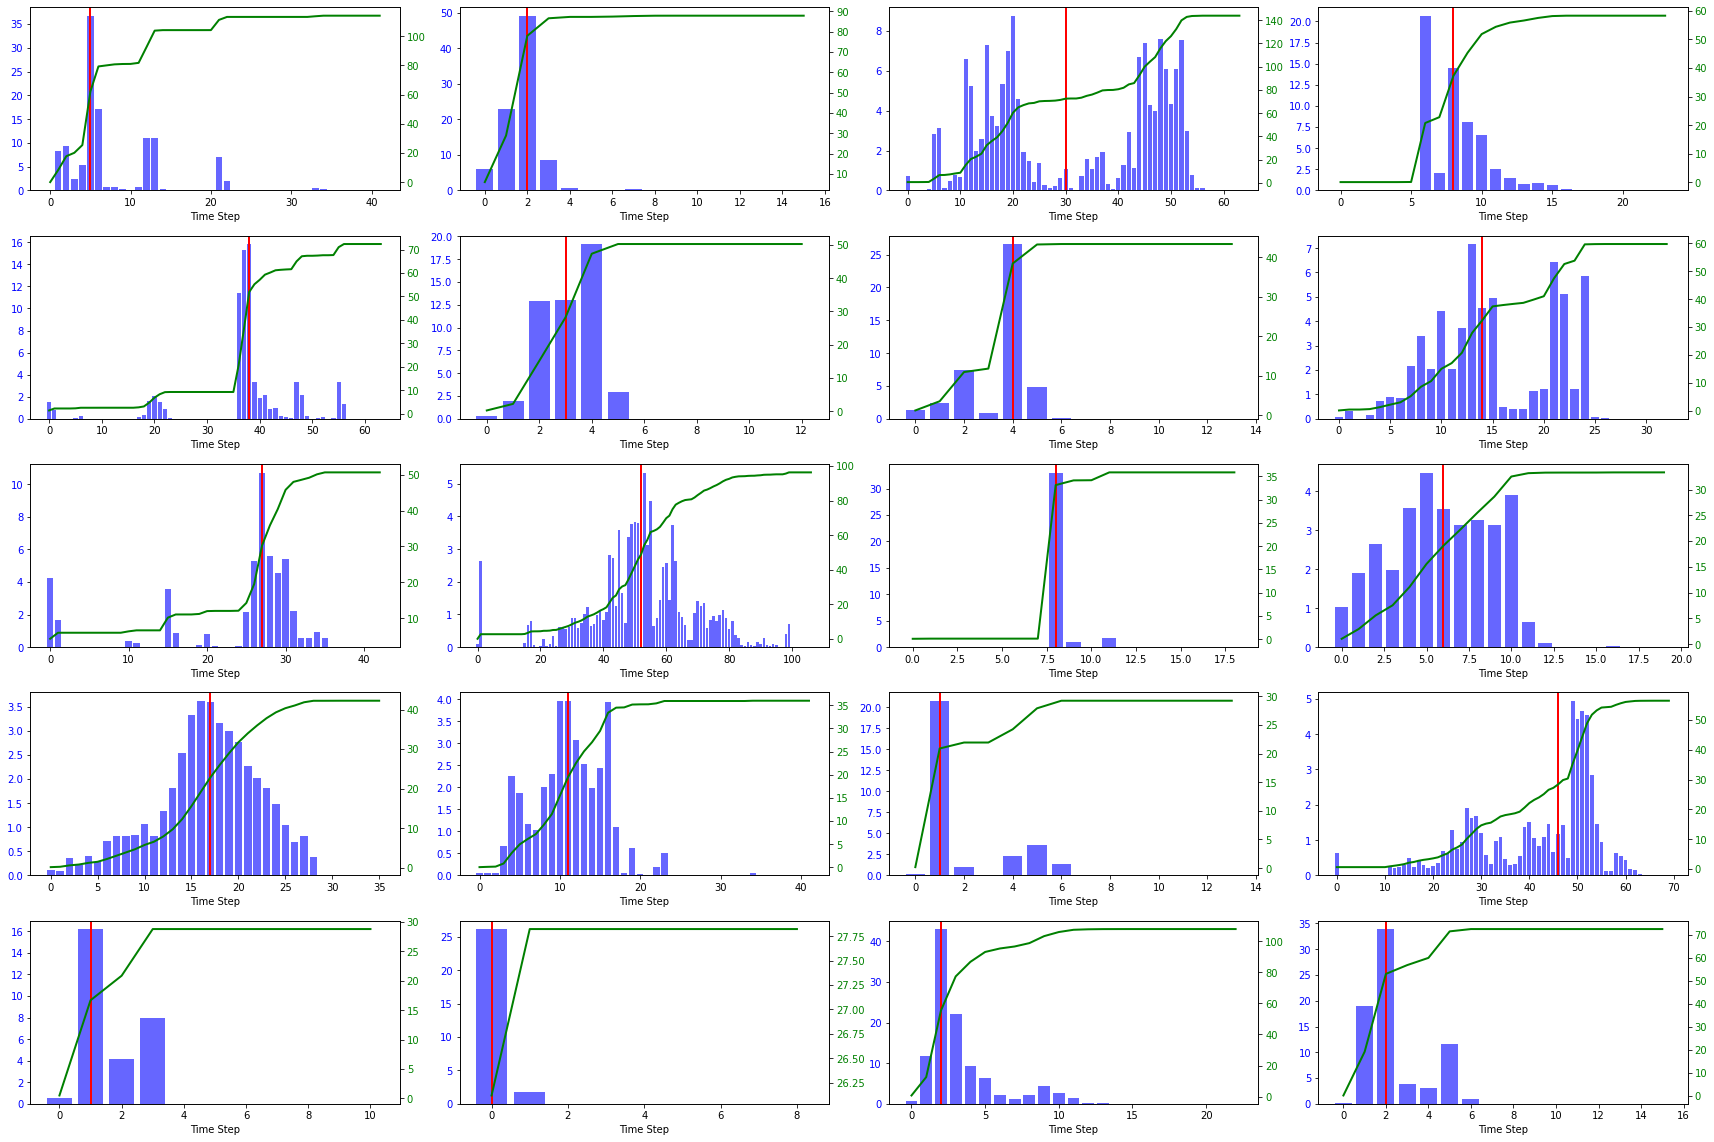

In [224]:
fig, axes = plt.subplots(5, 4, figsize=(24, 16))  # 2x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through events and plot each one in its subplot
for i in range(0,20):
    this_event = events_dict[i]
    D50, D50_index, cumulative_precip = calculate_D50(this_event['precipitation (mm)'])
    plot_precipitation_with_D50(axes[i], this_event['precipitation (mm)'], D50_index, cumulative_precip, D50)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()